In [17]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, sys
import matplotlib.style as style; style.use('fivethirtyeight')
from scipy.stats import zscore, norm

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

In [18]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
bank = pd.read_csv("C:/Users/kit25/Downloads/Bank_Personal_Loan_Modelling.csv")
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [20]:
display(bank['Personal Loan'].value_counts(), bank['Personal Loan'].value_counts(normalize = True)*100)


Personal Loan
0    4520
1     480
Name: count, dtype: int64

Personal Loan
0    90.4
1     9.6
Name: proportion, dtype: float64

In [21]:
bank.loc[bank['Experience'] < 0].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,52.0,2427.346154,1478.834118,90.0,767.25,2783.5,3669.500,4958.0
Age,52.0,24.519231,1.475159,23.0,24.00,24.0,25.000,29.0
Experience,52.0,-1.442308,0.639039,-3.0,-2.00,-1.0,-1.000,-1.0
Income,52.0,69.942308,37.955295,12.0,40.75,65.5,86.750,150.0
ZIP Code,52.0,93240.961538,1611.654806,90065.0,92167.75,93060.0,94720.000,95842.0
Family,52.0,2.865385,0.970725,1.0,2.00,3.0,4.000,4.0
CCAvg,52.0,2.129423,1.750562,0.2,1.00,1.8,2.325,7.2
Education,52.0,2.076923,0.836570,1.0,1.00,2.0,3.000,3.0
Mortgage,52.0,43.596154,90.027068,0.0,0.00,0.0,0.000,314.0
Personal Loan,52.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


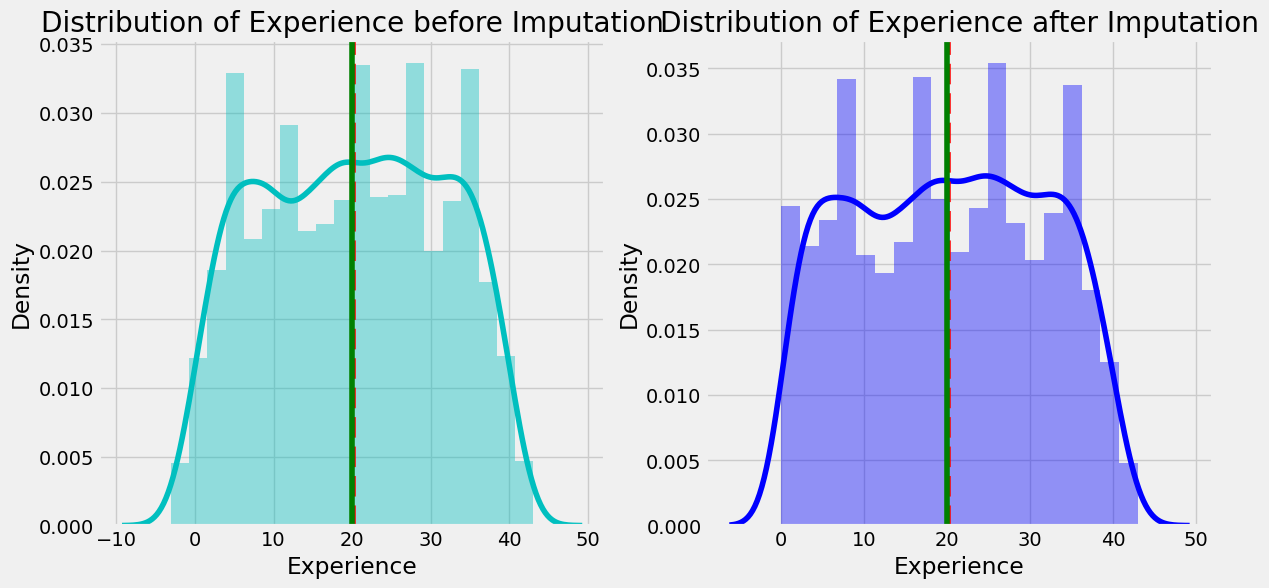

In [22]:
# Checking distribution of Experience column before and after imputation
fig = plt.figure(figsize=(12.8, 6))

ax = fig.add_subplot(121)
sns.distplot(bank['Experience'], color = 'c', ax = ax).set_title('Distribution of Experience before Imputation')
ax.axvline(bank['Experience'].mean(), color = 'r', linestyle = '--', label = 'Mean')
ax.axvline(bank['Experience'].median(), color = 'g', linestyle = '-', label = 'Median')

replace_value = bank.loc[(bank['Age'] > 23) & (bank['Age'] <= 29) & (bank['Income'] > 12) & (bank['Income'] < 150) & 
         (bank['Personal Loan'] == 0) & (bank['CD Account'] == 0), 'Experience'].median()

# replacing the negative values with 2
bank['Experience'] = np.where(bank['Experience'] < 0, replace_value, bank['Experience'])

ax = fig.add_subplot(122)
sns.distplot(bank['Experience'], color = 'b', ax = ax).set_title('Distribution of Experience after Imputation')
ax.axvline(bank['Experience'].mean(), color = 'r', linestyle = '--', label = 'Mean')
ax.axvline(bank['Experience'].median(), color = 'g', linestyle = '-', label = 'Median')


In [23]:
bank['Experience'].describe()

count    5000.000000
mean       20.140400
std        11.405644
min         0.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

In [25]:
cat_cols = ['ZIP Code', 'Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
bank[cat_cols].nunique()

ZIP Code              467
Family                  4
Education               3
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

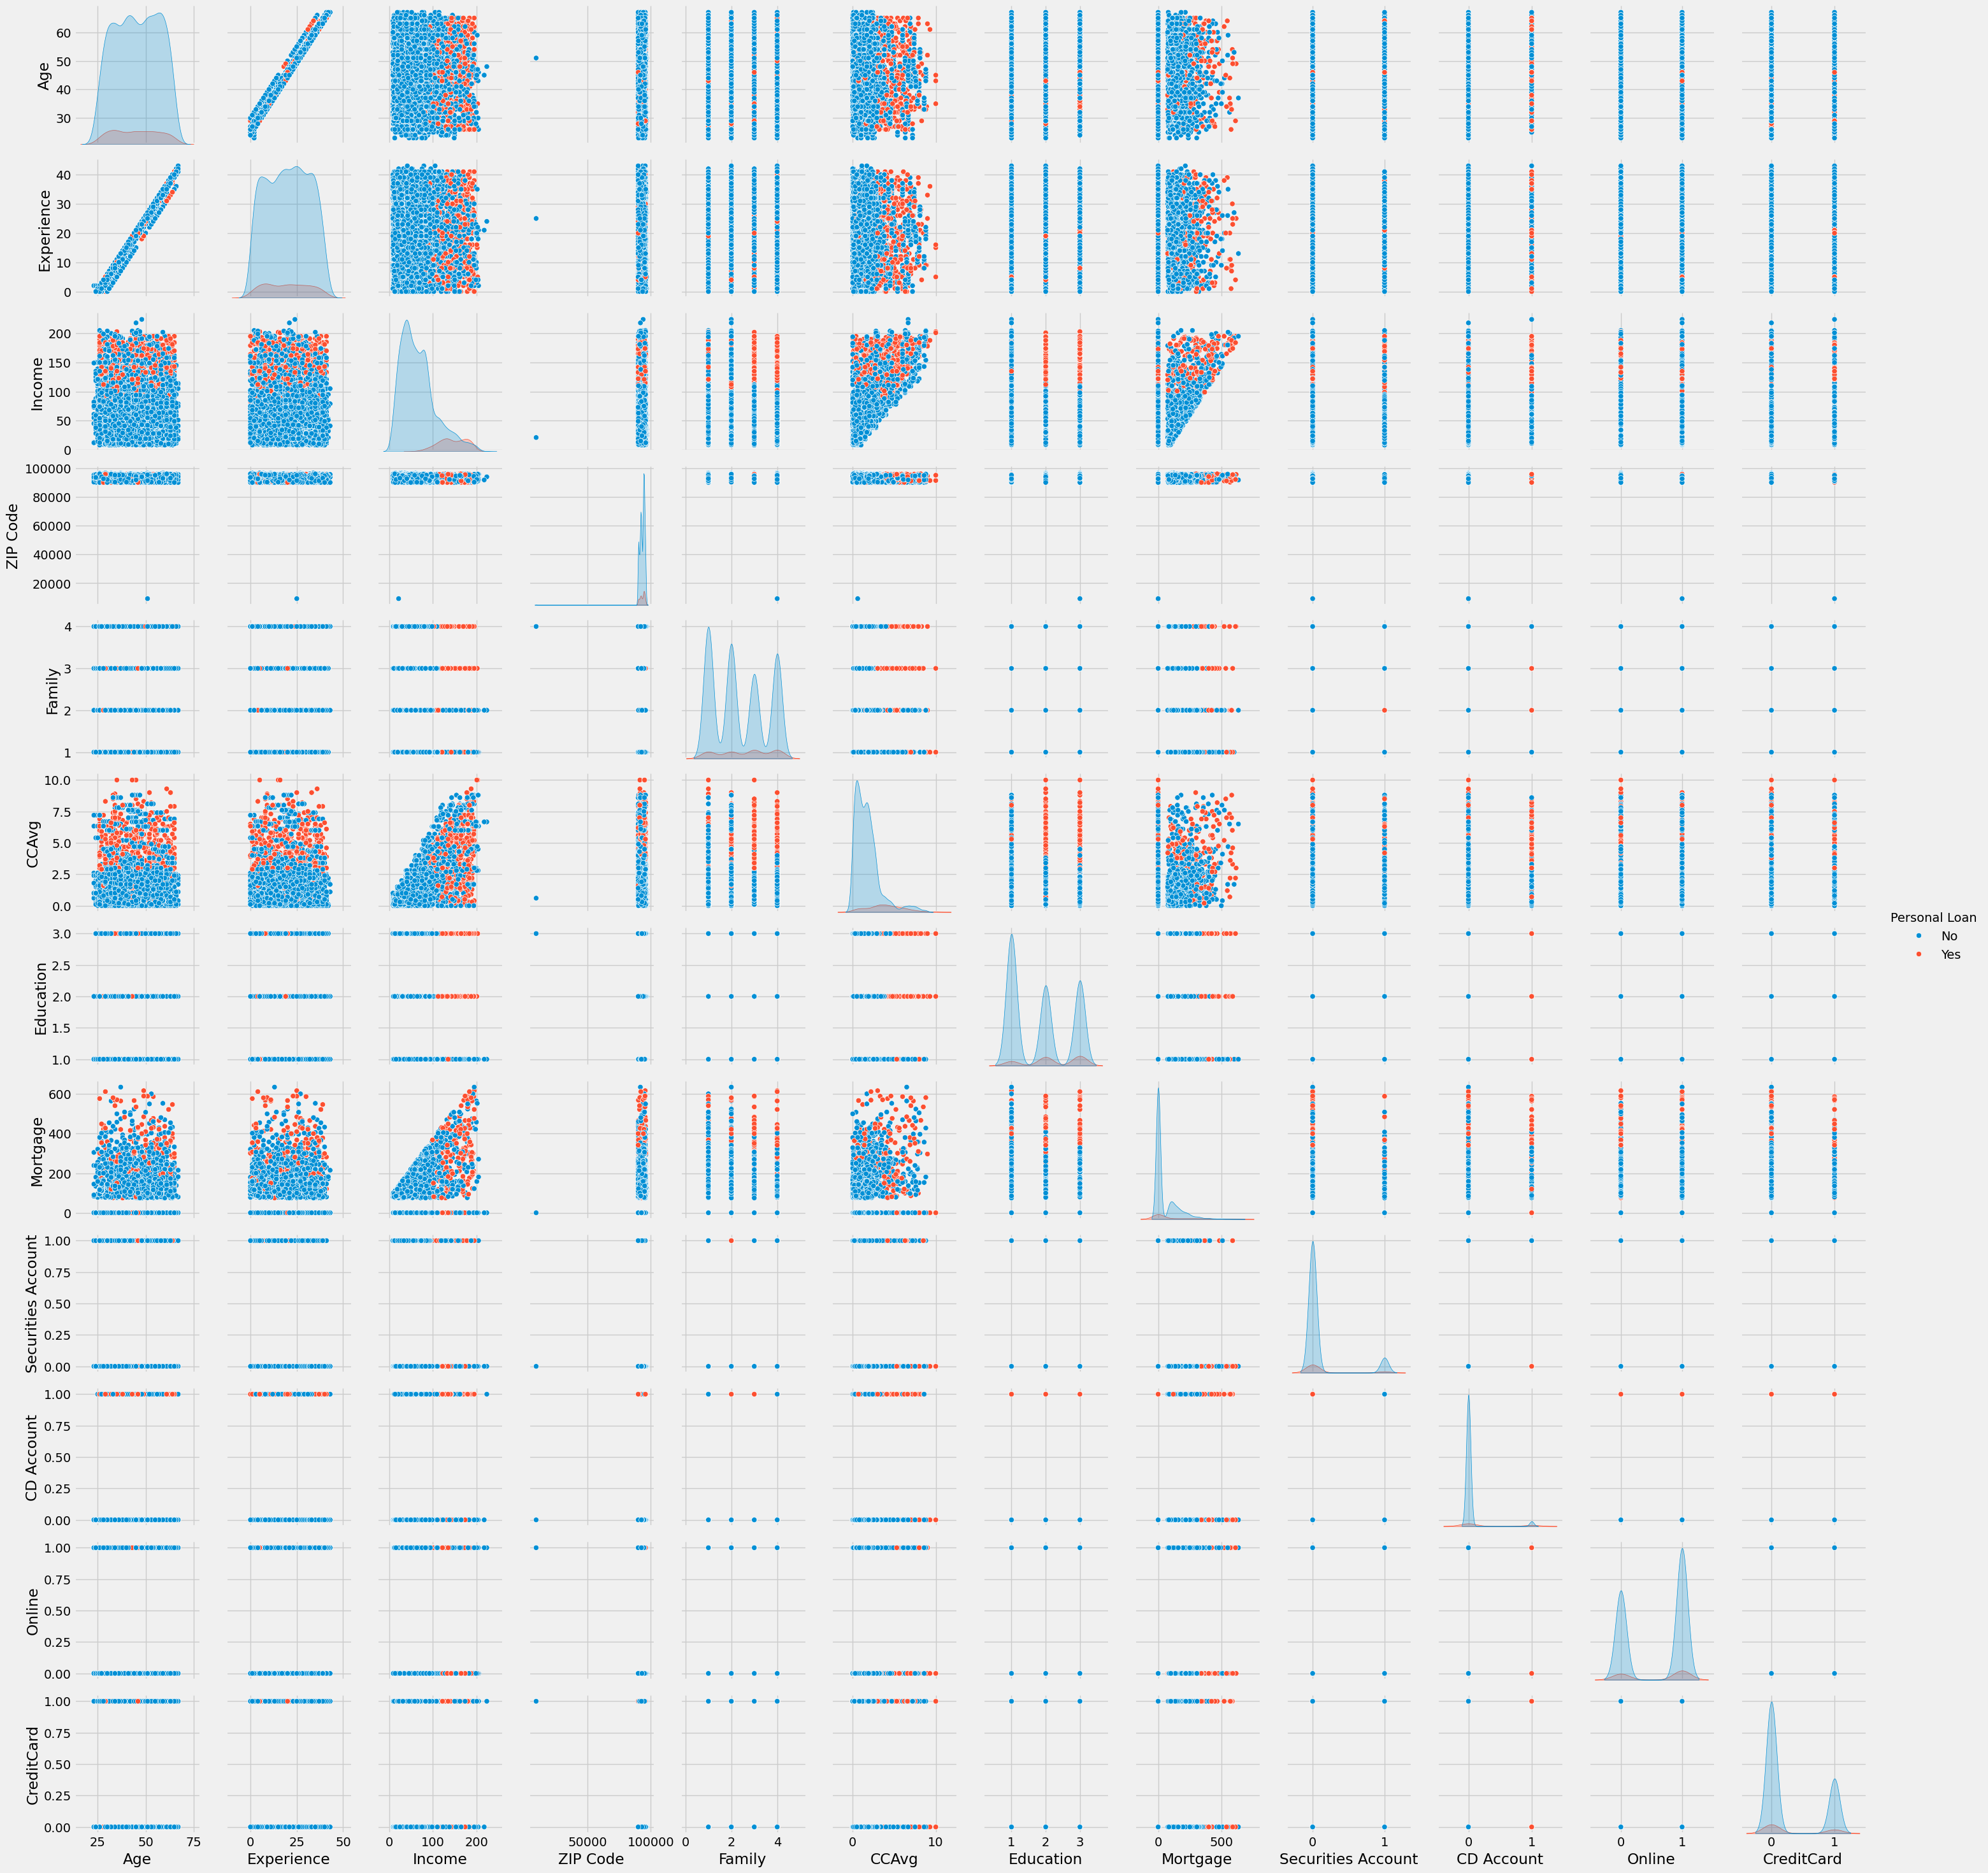

In [24]:
pairplt = bank.drop('ID', axis = 1)
pairplt['Personal Loan'] = pairplt['Personal Loan'].replace({0: 'No', 1: 'Yes'})
sns.pairplot(pairplt, hue = 'Personal Loan')

In [26]:
bank.drop(['ID', 'ZIP Code'], axis = 1, inplace = True)
bank.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account',
       'Online', 'CreditCard'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix of Data')

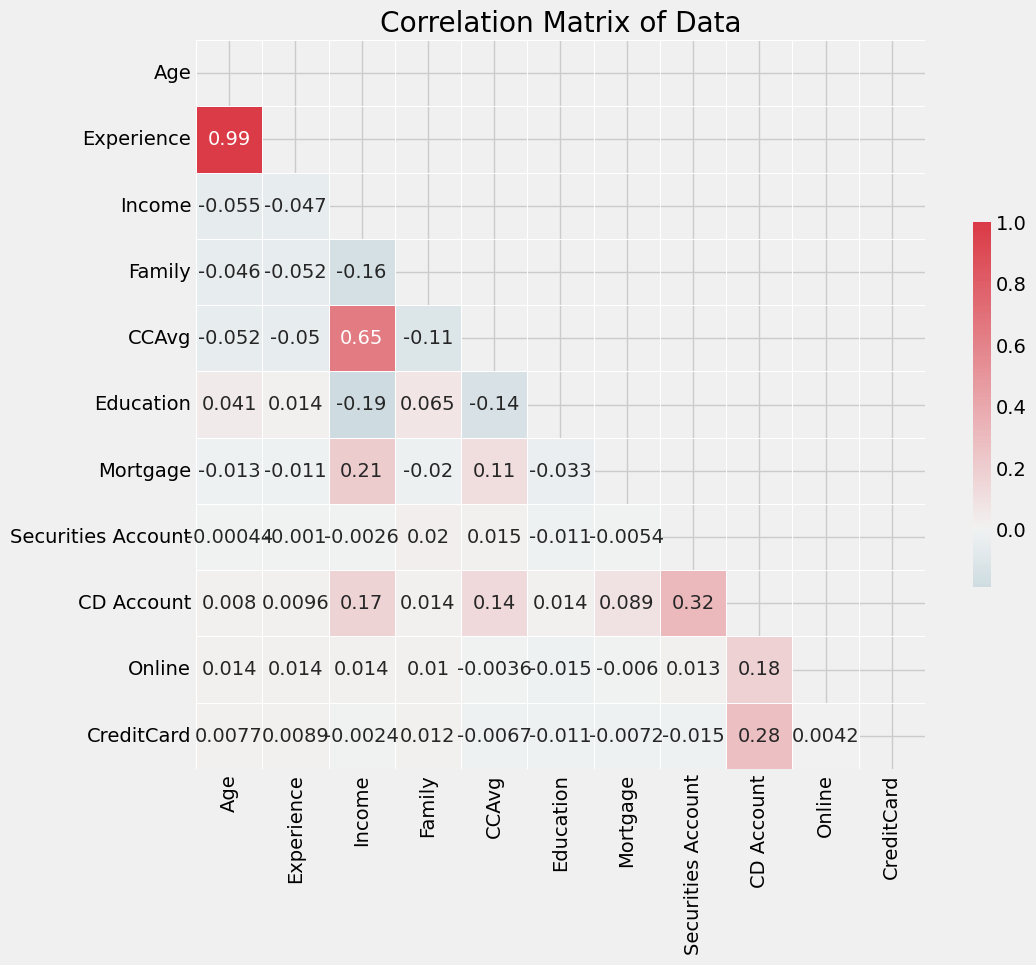

In [27]:
# Correlation matrix for all variables
corr = bank.drop('Personal Loan', axis = 1).corr()

mask = np.zeros_like(corr, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')

In [28]:
sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
sort[(sort > 0.5) & (sort < 1)]

Experience  Age           0.993922
Age         Experience    0.993922
CCAvg       Income        0.645984
Income      CCAvg         0.645984
dtype: float64

In [29]:
absCorrwithDep = []
allVars = bank.drop('Personal Loan', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(bank['Personal Loan'].corr(bank[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

,Variable,Correlation
2,Income,0.502462
4,CCAvg,0.366889
8,CD Account,0.316355
6,Mortgage,0.142095
5,Education,0.136722
3,Family,0.061367
7,Securities Account,0.021954
1,Experience,0.008477
0,Age,0.007726
9,Online,0.006278


In [30]:
# dropping age column
bank.drop(['Age', 'Online', 'CreditCard'], axis = 1, inplace = True)
bank.columns

Index(['Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'Personal Loan', 'Securities Account', 'CD Account'],
      dtype='object')

In [31]:
# Separating dependent and independent variables
X = bank.drop(['Personal Loan'], axis = 1)
y = bank['Personal Loan']

display(X.describe().T, X.shape, y.shape)

,count,mean,std,min,25%,50%,75%,max
Experience,5000.0,20.140400,11.405644,0.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Securities Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0
CD Account,5000.0,0.060400,0.238250,0.0,0.0,0.0,0.0,1.0


(5000, 8)

(5000,)

In [32]:
# Splitting the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3500, 8)

(1500, 8)

(3500,)

(1500,)

Logistic Regression Scores without Hyperparameter Tuning


LR accuracy for train set: 0.913
LR accuracy for test set: 0.899

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1343
           1       0.53      0.31      0.39       157

    accuracy                           0.90      1500
   macro avg       0.73      0.64      0.67      1500
weighted avg       0.88      0.90      0.89      1500


Confusion Matrix:
 [[1301   42]
 [ 109   48]]

Accuracy Score:
 0.899


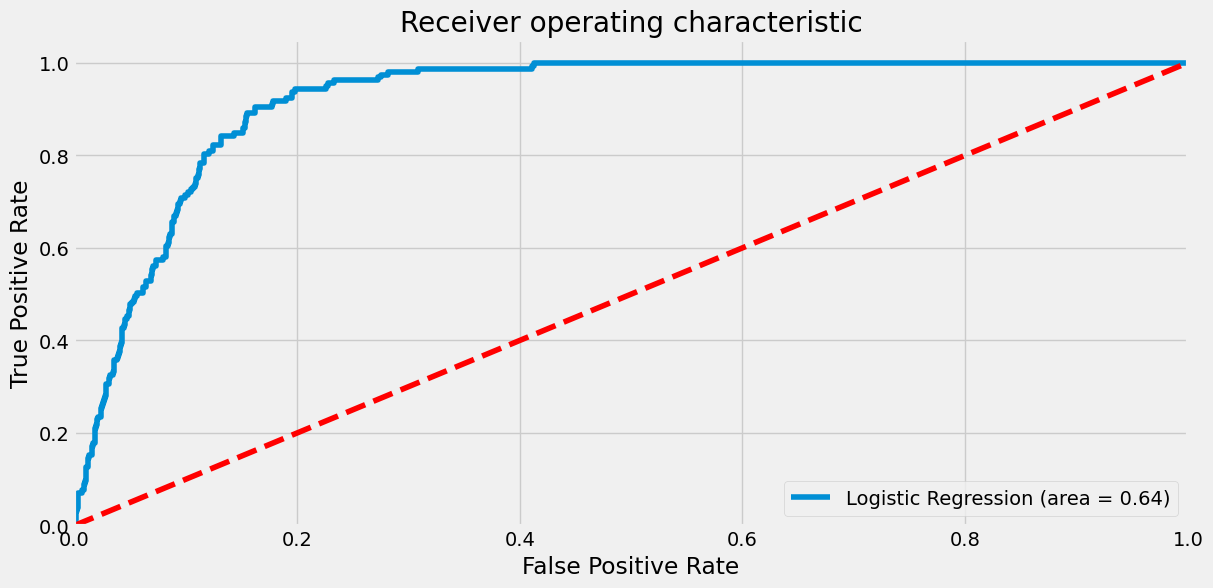

In [10]:
# LR model without hyperparameter tuning
LR = LogisticRegression()
LR.fit(X_train, y_train)

print('Logistic Regression Scores without Hyperparameter Tuning\n\n')
print('LR accuracy for train set: {0:.3f}'.format(LR.score(X_train, y_train)))
print('LR accuracy for test set: {0:.3f}'.format(LR.score(X_test, y_test)))

y_true, y_pred = y_test, LR.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
LR_roc_auc = roc_auc_score(y_true, LR.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, LR.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'Logistic Regression (area = {})'.\
         format(LR_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3500, 8)

(1500, 8)

(3500,)

(1500,)

k-Nearest Neighbor Classifier Scores without feature scaling


k-NN accuracy for train set: 0.943
k-NN accuracy for test set: 0.906

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1343
           1       0.59      0.33      0.42       157

    accuracy                           0.91      1500
   macro avg       0.76      0.65      0.69      1500
weighted avg       0.89      0.91      0.89      1500


Confusion Matrix:
 [[1307   36]
 [ 105   52]]

Accuracy Score:
 0.906


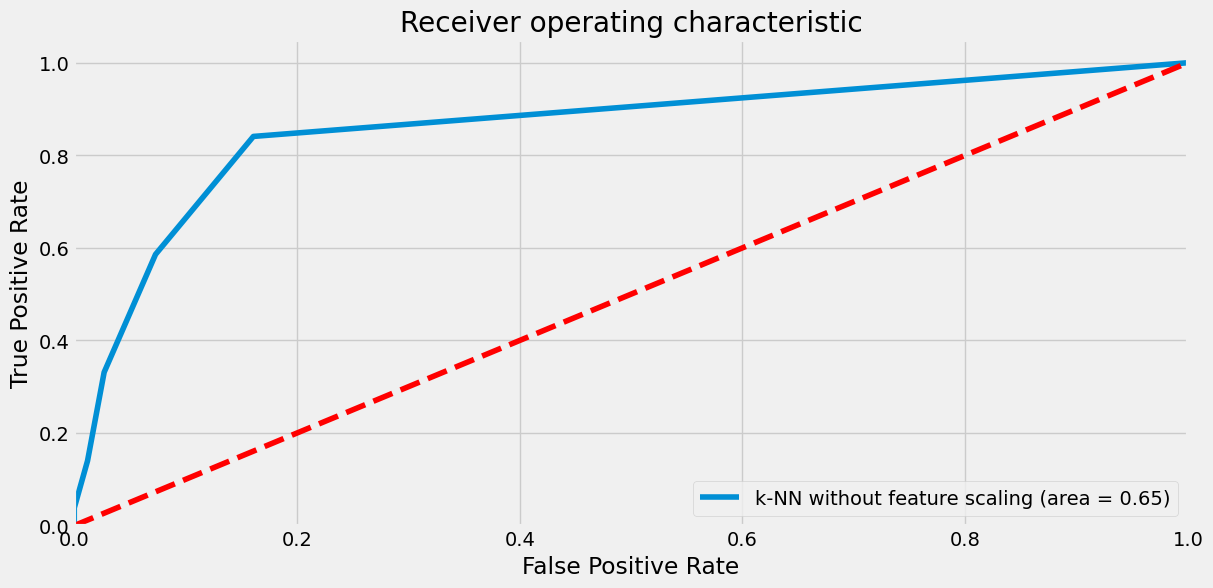

In [40]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

print('k-Nearest Neighbor Classifier Scores without feature scaling\n\n')
print('k-NN accuracy for train set: {0:.3f}'.format(KNN.score(X_train, y_train)))
print('k-NN accuracy for test set: {0:.3f}'.format(KNN.score(X_test, y_test)))

y_true, y_pred = y_test, KNN.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
KNN_roc_auc = roc_auc_score(y_true, KNN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, KNN.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'k-NN without feature scaling (area = {})'.\
         format(KNN_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [14]:
Xs = X.apply(zscore)
display(Xs.describe().T, Xs.shape, y.shape)

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,0.000000e+00,1.0001,-1.731704,-0.865852,0.000000,0.865852,1.731704
Age,5000.0,-2.131628e-18,1.0001,-1.948906,-0.901970,-0.029524,0.842923,1.889859
Experience,5000.0,4.192202e-17,1.0001,-1.766004,-0.889158,-0.012311,0.864536,2.004436
Income,5000.0,1.449507e-16,1.0001,-1.428969,-0.755483,-0.212348,0.526315,3.263712
ZIP Code,5000.0,1.428191e-15,1.0001,-39.519194,-0.585162,0.134093,0.686024,1.648959
Family,5000.0,1.001865e-16,1.0001,-1.216855,-1.216855,-0.345432,0.525991,1.397414
CCAvg,5000.0,-6.394885e-17,1.0001,-1.108987,-0.708412,-0.250611,0.321641,4.613525
Education,5000.0,2.557954e-17,1.0001,-1.049078,-1.049078,0.141703,1.332484,1.332484
Mortgage,5000.0,-5.613288e-17,1.0001,-0.555524,-0.555524,-0.555524,0.437558,5.688108
Securities Account,5000.0,-2.273737e-17,1.0001,-0.341423,-0.341423,-0.341423,-0.341423,2.928915


(5000, 13)

(5000,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [35]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [36]:
predictions = KNN.predict(X_test)

threshold = 0.5
accepted_predictions = predictions > threshold
print("Number of customers predicted to accept the loan:", sum(accepted_predictions))

Number of customers predicted to accept the loan: 88


In [37]:
import gradio as gr
import numpy as np

# Assuming you have a trained model stored in 'your_trained_model'

# Function to make predictions using the trained model
def predict_loan_acceptance(experience, income, family, ccavg, education, mortgage, securities_account, cd_account):
    # Convert input features to appropriate data types
    experience = float(experience)
    income = float(income)
    family = float(family)
    ccavg = float(ccavg)
    education = float(education)
    mortgage = float(mortgage)
    securities_account = float(securities_account)
    cd_account = float(cd_account)

    # Create a numpy array with the input features
    input_data = np.array([[experience, income, family, ccavg, education, mortgage, securities_account, cd_account]])

    # Use your trained model to make predictions
    # Replace 'your_trained_model' with the actual variable containing your trained model
    predictions = KNN.predict(input_data)

    # Assuming your model outputs probabilities, you might use a threshold
    threshold = 0.5
    accepted = predictions[0] > threshold

    # Return the prediction result
    return "Accepted" if accepted else "Not Accepted"

# Define the Gradio interface
iface = gr.Interface(
    fn=predict_loan_acceptance,
    inputs=[
        gr.Number(label="Experience"),
        gr.Number(label="Income"),
        gr.Number(label="Family"),
        gr.Number(label="CCAvg"),
        gr.Number(label="Education"),
        gr.Number(label="Mortgage"),
        gr.Number(label="Securities Account"),
        gr.Number(label="CD Account"),
    ],
    outputs=gr.Textbox(),
    live=True,
    title="Loan Acceptance Prediction",
    description="Enter customer features for prediction.",
)

# Launch the Gradio interface
iface.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.



k-Nearest Neighbor Classifier Scores without feature scaling




Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


k-NN accuracy for train set: 0.943
k-NN accuracy for test set: 0.906

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1343
           1       0.59      0.33      0.42       157

    accuracy                           0.91      1500
   macro avg       0.76      0.65      0.69      1500
weighted avg       0.89      0.91      0.89      1500


Confusion Matrix:
 [[1307   36]
 [ 105   52]]

Accuracy Score:
 0.906


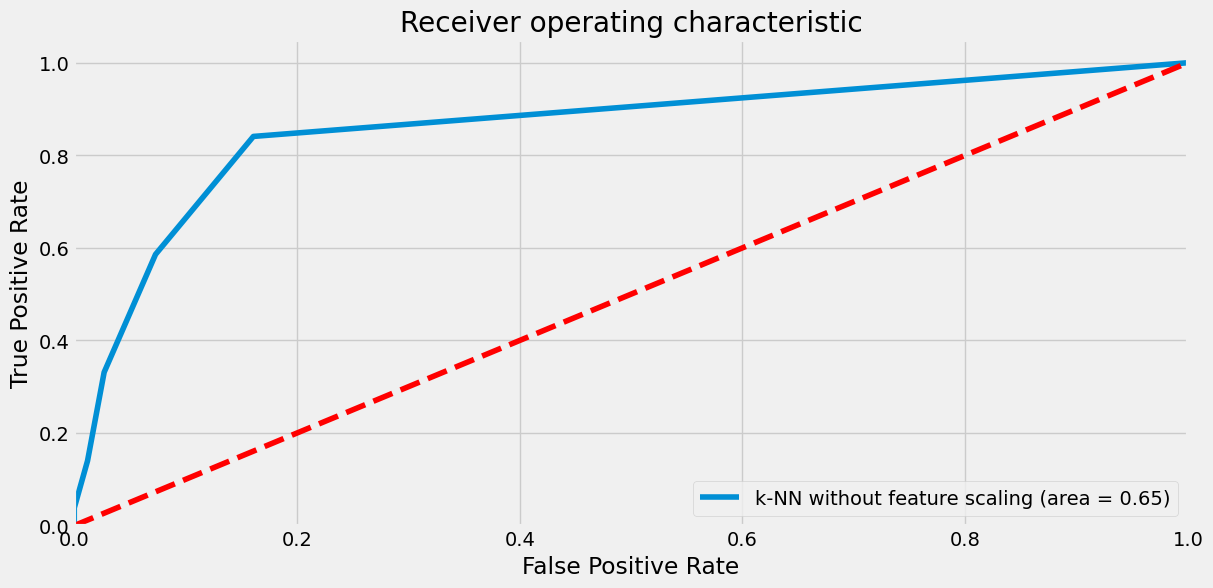

In [41]:
%pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()  
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

print('k-Nearest Neighbor Classifier Scores without feature scaling\n\n')
print('k-NN accuracy for train set: {0:.3f}'.format(KNN.score(X_train, y_train)))
print('k-NN accuracy for test set: {0:.3f}'.format(KNN.score(X_test, y_test)))

y_true, y_pred = y_test, KNN.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
KNN_roc_auc = roc_auc_score(y_true, KNN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, KNN.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'k-NN without feature scaling (area = {})'.\
         format(KNN_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()